# Model Selection for Polynomial Regression

In [1]:
import sys
sys.path.append('../..')

In [2]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(8, 4)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Generating Data Sets

$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0,0.1)$$

In [5]:
maxdegree = 20                      # maximum degree of the polynomial
n_train, n_test = 100, 1000         # training and test data set sizes
true_w = nd.zeros(maxdegree)        # allocate lots of empty space
true_w[0:4] = nd.array([5, 1.2, -3.4, 5.6])

features = nd.random.normal(shape=(n_train + n_test, 1))
features = nd.random.shuffle(features)
poly_features = nd.power(features, nd.arange(maxdegree).reshape((1,-1)))
poly_features = poly_features / (nd.gamma(nd.arange(maxdegree)+1).reshape((1,-1)))
labels = nd.dot(poly_features, true_w)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

### Defining, Training and Testing Model

In [6]:
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    # Switch off the bias since we already catered for it in the polynomial features
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})
    num_epochs, loss, train_ls, test_ls = 100, gloss.L2Loss(), [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        evaluate = lambda X, y: loss(net(X), y).mean().asscalar()
        train_ls.append(evaluate(train_features, train_labels))
        test_ls.append(evaluate(test_features, test_labels))
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])

### Third-order Polynomial Function Fitting (Normal)

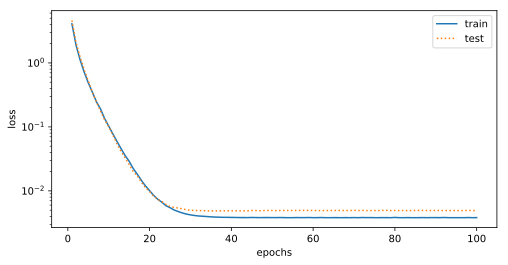

In [7]:
# Pick the first four dimensions, i.e. 1, x, x^2, x^3 from the polynomial features
fit_and_plot(poly_features[:n_train, 0:4], poly_features[n_train:, 0:4],
             labels[:n_train], labels[n_train:])

### Linear Function Fitting (Underfitting)

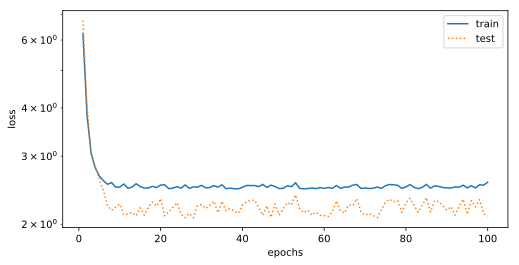

In [9]:
# Pick the first two dimensions, i.e. 1, x from the polynomial features
fit_and_plot(poly_features[:n_train, 0:3], poly_features[n_train:, 0:3],
             labels[:n_train], labels[n_train:])

### Insufficient Training (Overfitting)

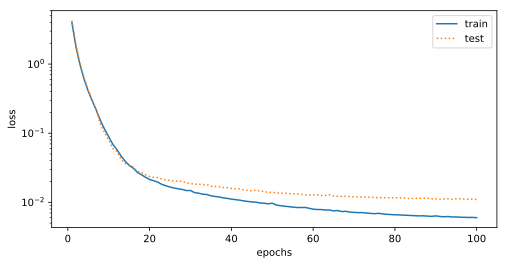

In [11]:
n_subset = 100  # subset of data to train on
n_degree = 20   # degree of polynomials
fit_and_plot(poly_features[:n_train, 0:n_degree], poly_features[n_train:, 0:n_degree],
             labels[:n_train,], labels[n_train:])